# Machine learning project 

## Predicting the disease type using X ray images 

### Data Exploration 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import cv2
%matplotlib inline

In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [3]:
train_data.head(5)

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [4]:
test_data.head(5)

,row_id,age,gender,view_position,image_name
0,id_100,47,M,0,scan_000100.png
1,id_10002,28,M,0,scan_00010002.png
2,id_10005,56,F,0,scan_00010005.png
3,id_10008,41,M,1,scan_00010008.png
4,id_10009,56,F,1,scan_00010009.png


In [5]:
print ('The train data has {} images.'.format(train_data.shape[0]))
print ('The test data has {} images.'.format(test_data.shape[0]))

The train data has 18577 images.
The test data has 12386 images.


In [6]:
train_data.describe()

,age,view_position
count,18577.000000,18577.000000
mean,47.972601,0.573343
std,16.741076,0.494605
min,2.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,414.000000,1.000000


In [7]:
test_data.describe()

,age,view_position
count,12386.000000,12386.000000
mean,48.028984,0.579445
std,16.660680,0.493668
min,1.000000,0.000000
25%,36.000000,0.000000
50%,50.000000,1.000000
75%,60.000000,1.000000
max,152.000000,1.000000


As we see that there is no skewness in the data and so the data is noise free.

### Loading Images

In [8]:
TRAIN_PATH = 'train_/'
TEST_PATH = 'test_/'
img = cv2.imread(TRAIN_PATH + 'scan_0000.png')

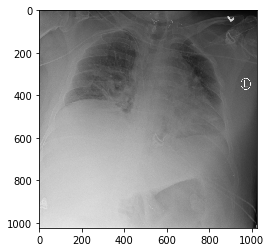

In [9]:
plt.imshow(img)

### Image processing

To process the image we use a technique called **histogram bias correction**. In this technique we process images with histogram equalization to increase contrast within each CXR image. It enhances the difference between the bone and empty space or tissue depicted in x-rays so as to make relevant information more prominent. All image processing steps were carried out using the python scikit image library

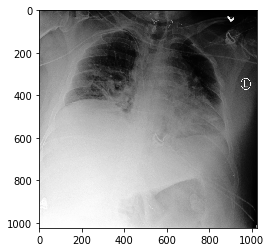

In [10]:
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]
plt.imshow(img2)

We can clearly make out the difference between the bone and empty space or tissue. This is clearly an improvement over the normal preprocessed image.

In [11]:
img2.shape

(1024, 1024, 3)

Unlike humans, a computer cannot recognise an image as it is. The computer cannot see shapes or colors. To a computer, any image is read as an array of numbers. It's an array of dimesion 1024 x 1024 x 3 where 1024 x 1024 is the number of pixels in rows and columns where as 3 represents the RGB color spectrum. Each number in the array is the value of the pixel which ranges from 0-255.

While we can load all the images in the same way, processing 18000 images of size 1024x1024 require enormous computation power. Instead, we resize them to a more appropriate sizes.

In [12]:
img2 = cv2.resize(img2, (128,128))

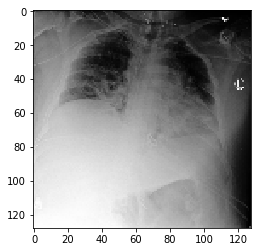

In [13]:
plt.imshow(img2)

This the how the resized image looks like. There may be some loss of data but this is neccessary since our computational power is limited 

Now we will load all our images and will process the same.

In [14]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128))
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img = cdf[img]
    return img

This function reads an image, resizes it to 128 x 128 and then applies histogram bias correction to increase the contrast.

In [15]:
from tqdm import tqdm # tqdm is a library which shows the iterations of the image being loaded into the list
train_img = []
for img_path in tqdm(train_data['image_name'].values):
    train_img.append(read_img(TRAIN_PATH + img_path))

100%|██████████| 18577/18577 [09:23<00:00, 32.94it/s]


Now loading the images into train_img list. The length of this is the number of instances.

In [16]:
print (len(train_img))

18577


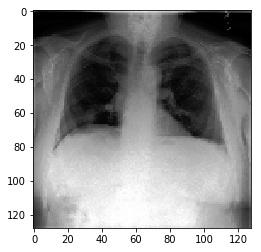

In [17]:
plt.imshow(train_img[5988])

Scaling the input image pixels to the range [0, 1] .

In [18]:
x_train_img = np.array(train_img, np.float32) / 255. #[0-255] -> [0,1]

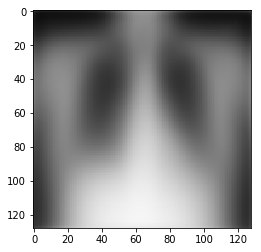

In [19]:
mean_img = np.mean(x_train_img,axis=0)
std_img = np.std(x_train_img,axis=0)
plt.imshow(mean_img)

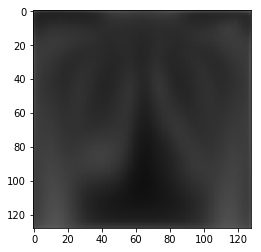

In [20]:
plt.imshow(std_img)

The reason we calculate these things is because in the process of training our network, we're going to multiply (weights) and add to (biases) these initial inputs in order to cause activations so that we can backpropogate with the gradients to train the model.

We'd like to have each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

While we can pass x_train as it is to our learning model, it is better to normalize it first. Normalizing both the train and test data for this problem can result in as much as a 12% increase in accuracy.

We normalize it using this formula: **X = (x - mean of x) / standard deviation of x.**

In [21]:
x_train_norm = (x_train_img - mean_img) / std_img

In [22]:
x_train_norm.shape

(18577, 128, 128, 3)

### Now saving the normalized image array so that it can used in **chest_xray_cnn_model** 

In [22]:
np.save('normalized_image_array', x_train_norm) # save the file as "outfile_name.npy" 

Switch to **chest_xray_cnn_model** file to check the cnn model 